In [1]:
from optim_relu_max_linear import OptimReluMaxLinear
from check_grad_optim_v import test_optim_splade_model
import triton
import torch

In [2]:
torch.cuda.is_available()

True

In [ ]:
test_optim_splade_model() # oblie ca, elle prend du temps

In [3]:
UPPER_LIMIT = 11  ## change ca pour diminuer la consommation de memoire.
x_vals = [64 * i for i in range(1, UPPER_LIMIT)]

In [4]:
print(x_vals)

[64, 128, 192, 256, 320, 384, 448, 512, 576, 640]


In [5]:
configs = []

configs.append(
    triton.testing.Benchmark(
        x_names=["V", "B", "L", "D"],  # Argument names to use as an x-axis for the plot
        x_vals=x_vals,  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals= ["torch", "triton"],  # Label name for the lines
        line_names= ["torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GB/s",  # Label name for the y-axis
        plot_name="relu_max_backward_performance",
        args={},
    ))


In [6]:
@triton.testing.perf_report(configs)
def benchmark(V, B, L, D, provider):
    x = torch.randn(B, L, D, requires_grad=True, dtype=torch.float64, device='cuda')
    w = torch.randn(D, V, requires_grad=True, dtype=torch.float64, device='cuda')
    b = torch.randn(V, requires_grad=True, dtype=torch.float64, device='cuda')
    list_lengths = torch.randint(0, L, [B])
    mask = torch.ones(B, L).cuda()
    for i, l in enumerate(list_lengths):
        mask[i, l:] = 0
        
    mask_inf = torch.where(mask == 1, 0, -torch.inf)
    relu = torch.nn.ReLU()
    
    torch_calculation = relu(torch.max((x @ w) + b.reshape(1, 1, *b.shape) + mask_inf.reshape(*mask_inf.shape, 1), dim=1)[0])
    triton_calculation = OptimReluMaxLinear.apply(x, w, b, mask)[0]
        
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_calculation.sum().backward(retain_graph=True), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_calculation.sum().backward(retain_graph=True) , quantiles=quantiles)
    gbps = lambda ms: 8 * (B * L * D + D * V + V) / (ms * 1e-3) / (1024 ** 3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

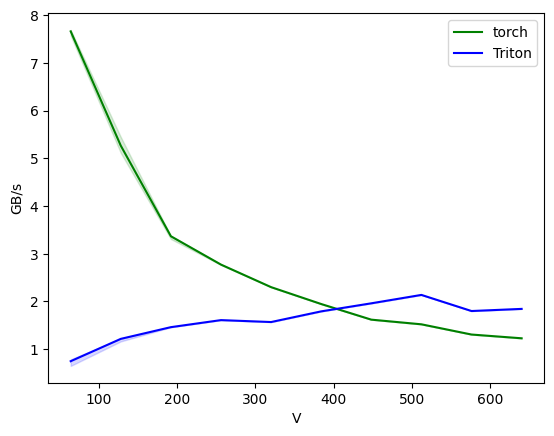

relu_max_backward_performance:
       V      B      L      D     torch    Triton
0   64.0   64.0   64.0   64.0  7.658564  0.746098
1  128.0  128.0  128.0  128.0  5.262251  1.214382
2  192.0  192.0  192.0  192.0  3.364769  1.459693
3  256.0  256.0  256.0  256.0  2.770377  1.607369
4  320.0  320.0  320.0  320.0  2.298170  1.566832
5  384.0  384.0  384.0  384.0  1.944430  1.790497
6  448.0  448.0  448.0  448.0  1.616909  1.959288
7  512.0  512.0  512.0  512.0  1.519298  2.135347
8  576.0  576.0  576.0  576.0  1.305069  1.797716
9  640.0  640.0  640.0  640.0  1.226240  1.842395


In [7]:
benchmark.run(show_plots=True, print_data=True)